<a href="https://colab.research.google.com/github/jackiet0rres/showcase/blob/main/ArtificialEEGData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Starts up the libraries

In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 26.0 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import scipy.io
from sklearn.model_selection import train_test_split
import urllib.request
import random
import torch.optim as optim
import mne

#Defining the Artificial EEG Data

In [3]:
#loads the full channel list from a BioSemi128 montage
montage = mne.channels.make_standard_montage('biosemi64')
all_chs = montage.ch_names

#categorize
LEFT_CHS = [ch for ch in all_chs if ch[-1].isdigit() and int(ch[-1]) % 2 == 1]
RIGHT_CHS = [ch for ch in all_chs if ch[-1].isdigit() and int(ch[-1]) % 2 == 0]
MIDLINE_CHS = [ch for ch in all_chs if ch.endswith('z')]

print(f"Left: {len(LEFT_CHS)} channels\n", LEFT_CHS)
print(f"Right: {len(RIGHT_CHS)} channels\n", RIGHT_CHS)
print(f"Midline: {len(MIDLINE_CHS)} channels\n", MIDLINE_CHS)

Left: 27 channels
 ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1']
Right: 27 channels
 ['Fp2', 'AF8', 'AF4', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
Midline: 10 channels
 ['Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'AFz', 'Fz', 'FCz', 'Cz']


Creating RawArray with float64 data, n_channels=64, n_times=300
    Range : 0 ... 299 =      0.000 ...     1.196 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=300
    Range : 0 ... 299 =      0.000 ...     1.196 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=300
    Range : 0 ... 299 =      0.000 ...     1.196 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=300
    Range : 0 ... 299 =      0.000 ...     1.196 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=300
    Range : 0 ... 299 =      0.000 ...     1.196 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=300
    Range : 0 ... 299 =      0.000 ...     1.196 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=300
    Range : 0 ... 299 =      0.000 ...     1.196 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=300
    Range : 0 ... 299 =      0.000 ...     1.196 secs
Ready.


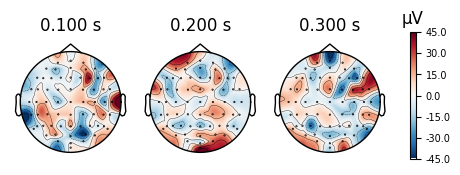

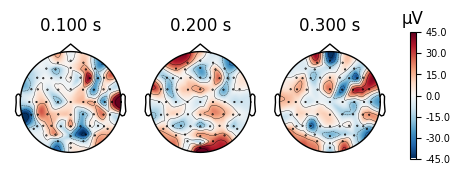

In [4]:
n_dyslexic, n_control = 30, 30
n_tasks = 3
n_epochs_per_task = 100
D = 64
T = 300
sfreq = 250  # Hz
epoch_duration = T / sfreq

erp_components = {
    "P1": (100, 7e-6, 20),
    "N1": (150, -9e-6, 50),
    "N2": (200, -8e-6, 40),
    "P3": (300, 7e-6, 50),
    "N400": (400, -7e-6, 50),
    "LPP": (600, 9e-6, 80)
}

LEFT_CHS = [ch for ch in all_chs if ch[-1].isdigit() and int(ch[-1]) % 2 == 1]
RIGHT_CHS = [ch for ch in all_chs if ch[-1].isdigit() and int(ch[-1]) % 2 == 0]
MIDLINE_CHS = [ch for ch in all_chs if ch.endswith('z')]


def generate_erp_waveform(times, dyslexic=False, task_type=0, rng=None, ch_name=None):
    waveform = np.zeros_like(times)
    for name, (_, amplitude, width) in erp_components.items():
        if dyslexic:
            latency_ms = rng.integers(600, 800)
        else:
            latency_ms = rng.integers(200, 400)

        latency_samples = int((latency_ms / 1000) * sfreq)
        latency_samples = np.clip(latency_samples, 0, len(times) - 1)

        ###adjusts amplitude depending on hemisphere
        if dyslexic:
            if ch_name in RIGHT_CHS:
                amplitude *= rng.uniform(0.2, 0.4)
            elif ch_name in LEFT_CHS:
                amplitude *= rng.uniform(2.0, 3.0)
            elif ch_name in MIDLINE_CHS:
                amplitude *= rng.uniform(0.8, 1.2)
            else:
                amplitude *= rng.uniform(0.2, 0.4)
        else:
            if ch_name in RIGHT_CHS:
                amplitude *= rng.uniform(2.0, 3.0)
            elif ch_name in LEFT_CHS:
                amplitude *= rng.uniform(0.2, 0.4)
            elif ch_name in MIDLINE_CHS:
                amplitude *= rng.uniform(0.8, 1.2)
            else:
                amplitude *= rng.uniform(0.2, 0.4)

        amplitude *= rng.uniform(0.8, 1.2)
        waveform += amplitude * np.exp(-((times - times[latency_samples])**2) / (2 * (width / 1000) ** 2))


    waveform *= (1 + 0.80 * task_type)
    return waveform



def add_frequency_variations(eeg_data, dyslexic=False, rng=None):
    standard_montage = mne.channels.make_standard_montage("biosemi64")
    ch_names = standard_montage.ch_names[:eeg_data.shape[1]]
    ch_idx_map = {ch: idx for idx, ch in enumerate(ch_names)}

    for trial in range(eeg_data.shape[0]):
        for ch_idx, ch_name in enumerate(ch_names):
            if ch_name in RIGHT_CHS:
                freq = rng.uniform(15, 20) if not dyslexic else rng.uniform(5, 8)
            elif ch_name in LEFT_CHS:
                freq = rng.uniform(5, 8) if not dyslexic else rng.uniform(15, 20)
            else:
                freq = rng.uniform(10, 12)

            noise = np.sin(2 * np.pi * freq * np.linspace(0, 3, eeg_data.shape[2])) * 0.5e-6
            eeg_data[trial, ch_idx, :] += noise
    return eeg_data


def add_theta_bursts(eeg_data, dyslexic=False, rng=None):
    if not dyslexic:
        return eeg_data
    num_trials, num_channels, time_points = eeg_data.shape
    for trial in range(num_trials):
        for ch in range(num_channels):
            freq = rng.uniform(4, 7)
            phase = rng.uniform(0, 2 * np.pi)
            burst = 0.8e-6 * np.sin(2 * np.pi * freq * np.linspace(0, 3, time_points) + phase)
            eeg_data[trial, ch, :] += burst
    return eeg_data

def add_channelwise_gaussian_noise(eeg_data, rng=None):
    num_trials, num_channels, time_points = eeg_data.shape
    for trial in range(num_trials):
        for ch in range(num_channels):
            scale = rng.uniform(1e-6, 5e-6)  #vary scale between 1e-6 and 5e-6
            eeg_data[trial, ch, :] += rng.normal(scale=scale, size=time_points)
    return eeg_data


def add_non_gaussian_noise(eeg_data, dyslexic=False, rng=None):
    num_trials, num_channels, time_points = eeg_data.shape
    for trial in range(num_trials):
        for ch in range(num_channels):
            if dyslexic:
                noise = rng.laplace(scale=1e-10, size=time_points)
            else:
                noise = rng.normal(scale=1e-6, size=time_points)
            eeg_data[trial, ch, :] += noise
    return eeg_data

def get_spatial_weights(n_channels, dyslexic=False, rng=None):
    standard_montage = mne.channels.make_standard_montage("biosemi64")
    ch_names = standard_montage.ch_names[:n_channels]

    weights = np.ones(n_channels)

    left_weight = rng.uniform(2.5, 3.5) if dyslexic else rng.uniform(0.2, 0.4)
    right_weight = rng.uniform(0.2, 0.4) if dyslexic else rng.uniform(2.5, 3.5)
    midline_weight = rng.uniform(0.8, 1.2)

    for idx, ch in enumerate(ch_names):
        if ch in LEFT_CHS:
            weights[idx] = left_weight
        elif ch in RIGHT_CHS:
            weights[idx] = right_weight
        elif ch in MIDLINE_CHS:
            weights[idx] = midline_weight
        else:
            weights[idx] = rng.uniform(0.6, 1.0)


    return weights[None, :, None]



def add_gaussian_noise(eeg_data, scale=1e-6, rng=None):
    noise = rng.normal(scale=scale, size=eeg_data.shape)
    return eeg_data + noise

def normalize_channel_power(eeg_data):
    power = np.sqrt(np.mean(eeg_data ** 2, axis=2, keepdims=True))
    eeg_data /= power + 1e-12  ###prevents divide-by-zero
    eeg_data *= np.mean(power)  ###restores average power
    return eeg_data

#EEG Epoch Generator for One Task/Participant
def generate_synthetic_eeg(n_epochs, dyslexic=False, task_type=0):
    rng = np.random.default_rng()

    standard_montage = mne.channels.make_standard_montage("biosemi64")
    ch_names = standard_montage.ch_names[:D]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
    info.set_montage(standard_montage)

    raw = mne.io.RawArray(np.zeros((D, T)), info)

    epochs_data = []
    times = np.linspace(0, epoch_duration, T)

    for _ in range(n_epochs):
        eeg_data = np.zeros((D, T))
        for ch_idx, ch_name in enumerate(ch_names):
            phase_shift = rng.integers(-40, 40)
            shifted_times = np.clip(times + (phase_shift / 1000), 0, epoch_duration)
            erp = generate_erp_waveform(shifted_times, dyslexic=dyslexic, task_type=task_type, rng=rng, ch_name=ch_name)
            eeg_data[ch_idx, :] = erp


        eeg_data = eeg_data[np.newaxis, :, :]
        eeg_data = add_frequency_variations(eeg_data, dyslexic=dyslexic, rng=rng)
        eeg_data = add_non_gaussian_noise(eeg_data, dyslexic=dyslexic, rng=rng)
        eeg_data = add_theta_bursts(eeg_data, dyslexic=dyslexic, rng=rng)
        eeg_data = add_gaussian_noise(eeg_data, scale=5e-6, rng=rng)
        eeg_data = add_channelwise_gaussian_noise(eeg_data, rng=rng)

        # Modulate spatially
        weights = get_spatial_weights(D, dyslexic=dyslexic, rng=rng)
        eeg_data *= weights


        eeg_data = normalize_channel_power(eeg_data)
        eeg_data += rng.normal(scale=5e-6, size=(1, D, T))


        epochs_data.append(eeg_data[0])

    return np.array(epochs_data).reshape(n_epochs, D, T), info

#makes the full dataset
def generate_full_group_data(n_participants, n_tasks, n_epochs_per_task, dyslexic=False):
    all_data = []
    for _ in range(n_participants):
        for task in range(n_tasks):
            task_data, _ = generate_synthetic_eeg(n_epochs_per_task, dyslexic=dyslexic, task_type=task)
            all_data.append(task_data)
    return np.vstack(all_data)

dyslexic_data = generate_full_group_data(n_dyslexic, n_tasks, n_epochs_per_task, dyslexic=True)
control_data = generate_full_group_data(n_control, n_tasks, n_epochs_per_task, dyslexic=False)

print("Dyslexic shape:", dyslexic_data.shape)
print("Control shape:", control_data.shape)

_, info = generate_synthetic_eeg(n_epochs=1, dyslexic=True, task_type=0)
#topomap
evoked = mne.EvokedArray(dyslexic_data[0], info)
evoked.plot_topomap(times=[0.1, 0.2, 0.3])

#Prints out the EEG recording from the Control Participant 1 and Participant 30

No projector specified for this dataset. Please consider the method self.add_proj.


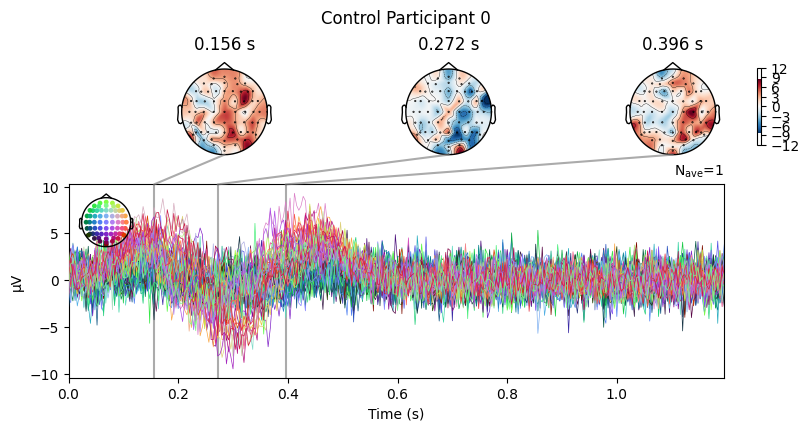

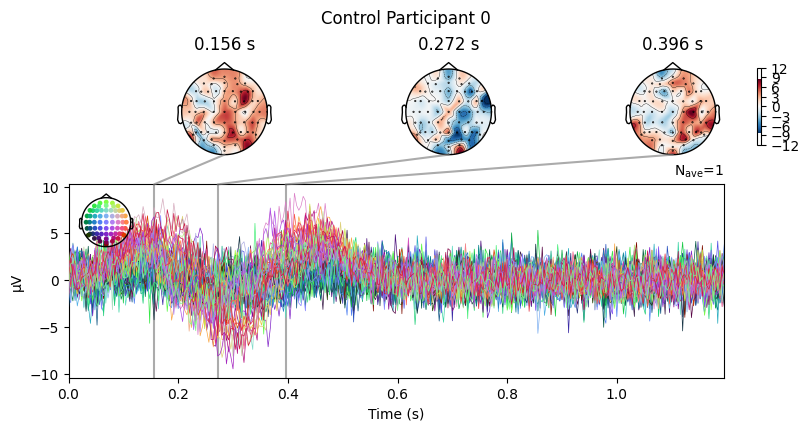

In [5]:
participant_id = 0
start_idx = participant_id * n_epochs_per_task
end_idx = start_idx + n_epochs_per_task

participant_epochs = control_data[start_idx:end_idx]
participant_erp = participant_epochs.mean(axis=0)

evoked_participant = mne.EvokedArray(participant_erp, info, tmin=0)
evoked_participant.plot_joint(title=f"Control Participant {participant_id}")

No projector specified for this dataset. Please consider the method self.add_proj.


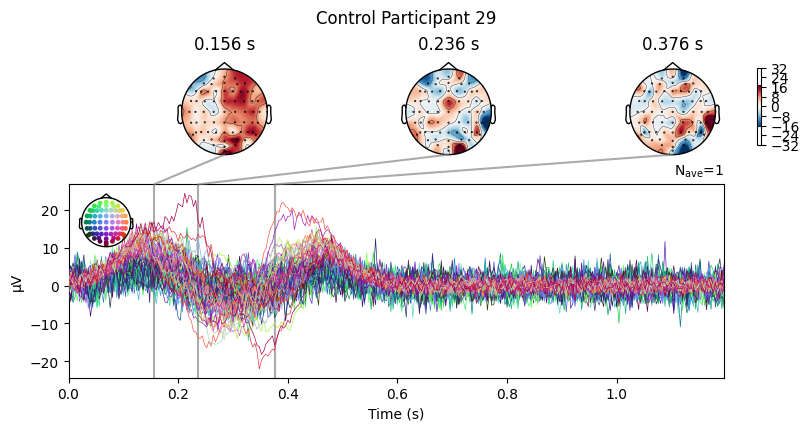

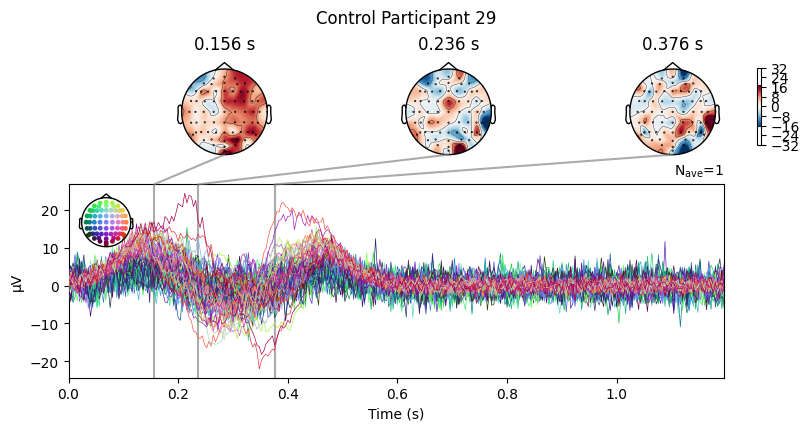

In [6]:
participant_id = 29
start_idx = participant_id * n_epochs_per_task
end_idx = start_idx + n_epochs_per_task

participant_epochs = control_data[start_idx:end_idx]
participant_erp = participant_epochs.mean(axis=0)

evoked_participant = mne.EvokedArray(participant_erp, info, tmin=0)
evoked_participant.plot_joint(title=f"Control Participant {participant_id}")

#Prints out the EEG recording from the Dyslexic Participant 1 and Participant 30

No projector specified for this dataset. Please consider the method self.add_proj.


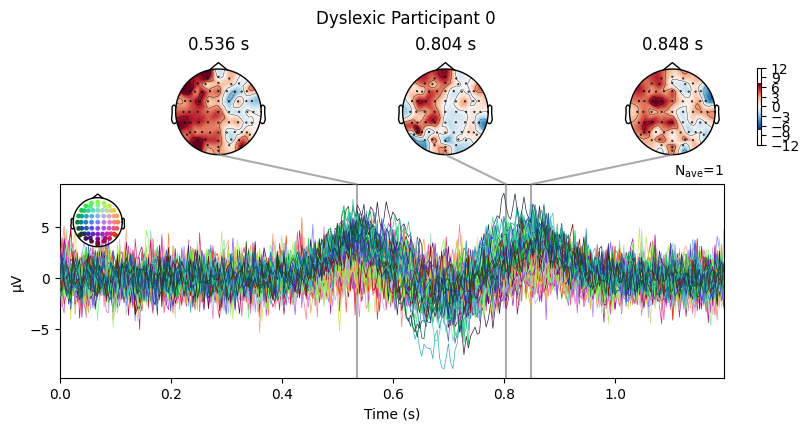

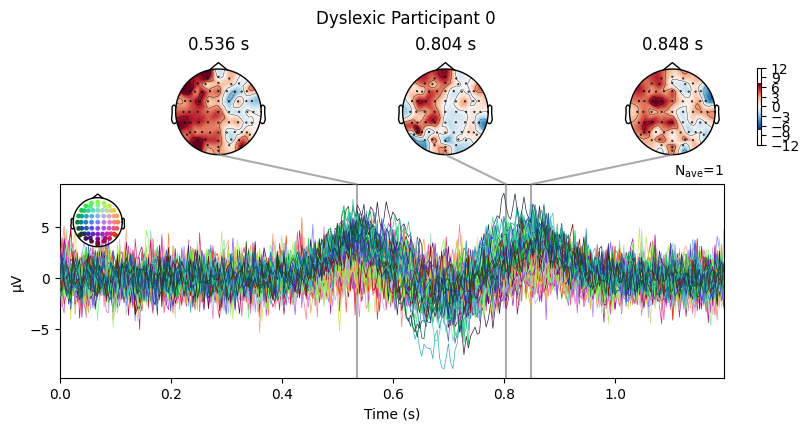

In [7]:
participant_id = 0
start_idx = participant_id * n_epochs_per_task
end_idx = start_idx + n_epochs_per_task

participant_epochs = dyslexic_data[start_idx:end_idx]
participant_erp = participant_epochs.mean(axis=0)

evoked_participant = mne.EvokedArray(participant_erp, info, tmin=0)
evoked_participant.plot_joint(title=f"Dyslexic Participant {participant_id}")

No projector specified for this dataset. Please consider the method self.add_proj.


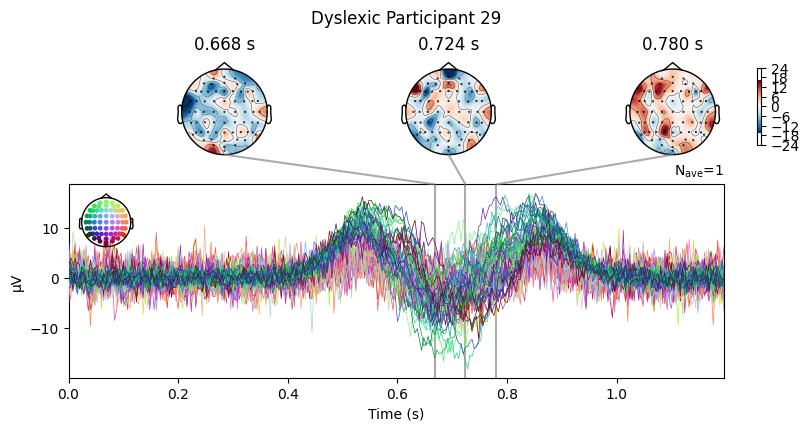

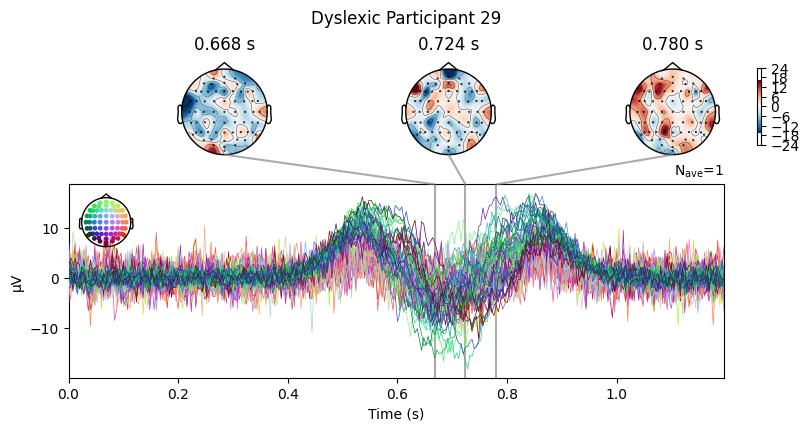

In [8]:
participant_id = 29
start_idx = participant_id * n_epochs_per_task
end_idx = start_idx + n_epochs_per_task

participant_epochs = dyslexic_data[start_idx:end_idx]
participant_erp = participant_epochs.mean(axis=0)

evoked_participant = mne.EvokedArray(participant_erp, info, tmin=0)
evoked_participant.plot_joint(title=f"Dyslexic Participant {participant_id}")